In [ ]:
import torch_ga
from torch_ga import TorchGA
import torch
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from time import perf_counter

import pygad

In [ ]:
pop_size = 200
genome_length = 1000

In [ ]:
def torchga_fitness(population: torch.Tensor):
  return population.float().mean(dim=-1)

def pygad_fitness(ga_instance, solution, solution_idx):
  return np.mean(solution)

In [ ]:
pygad_ga = partial(pygad.GA,
    num_parents_mating=100,
    fitness_func=pygad_fitness,
    sol_per_pop=pop_size,
    num_genes=genome_length,
    parent_selection_type="tournament",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=1,
    gene_type=int,
    init_range_low=0,
    init_range_high=2
)

In [ ]:
torch_ga_gpu = partial(TorchGA,
    initial_population=torch.randint(1, (pop_size, genome_length), device="cuda"),
    num_elites=10,
    fitness_function=torchga_fitness,
    selection_method='tournament',
    crossover_function='single point',
    mutation_function=torch_ga.mutation.BinaryMutation(mutation_rate=0.01),
)

torch_ga_cpu = partial(TorchGA,
    initial_population=torch.randint(1, (pop_size, genome_length), device="cpu"),
    num_elites=10,
    fitness_function=torchga_fitness,
    selection_method='tournament',
    crossover_function='single point',
    mutation_function=torch_ga.mutation.BinaryMutation(mutation_rate=0.01),
)

In [ ]:
torch_times = []
torch_times_cpu = []
pygad_times = []

generations = np.arange(100, 1100, 100)

In [ ]:
for gens in generations:
  pygad_ga_instance = pygad_ga(num_generations=gens)
  start = perf_counter()
  pygad_ga_instance.run()
  pygad_times.append(perf_counter() - start)

  torch.cuda.empty_cache()
  torch.cuda.synchronize()
  torch_ga_gpu_instance = torch_ga_gpu()
  start = perf_counter()
  torch_ga_gpu_instance.run_for(gens)
  torch_times.append(perf_counter() - start)

  torch_ga_cpu_instance = torch_ga_cpu()
  start = perf_counter()
  torch_ga_cpu_instance.run_for(gens)
  torch_times_cpu.append(perf_counter() - start)

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/m

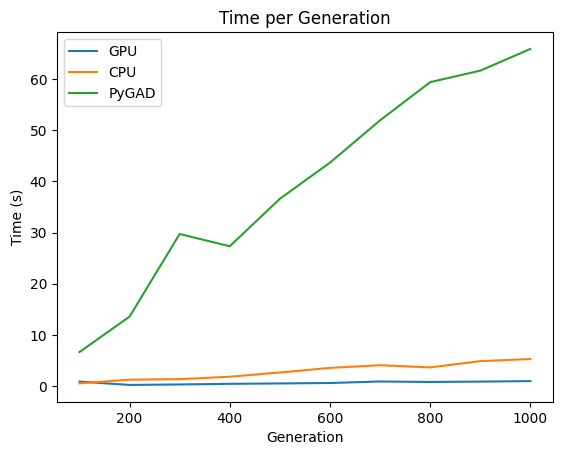

In [ ]:
plt.plot(generations, torch_times, label="GPU")
plt.plot(generations, torch_times_cpu, label="CPU")
plt.plot(generations, pygad_times, label="PyGAD")
plt.title("Time per Generation")
plt.xlabel("Generation")
plt.ylabel("Time (s)")
plt.legend()
plt.show()